In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from sunRay.parameters import c,c_r,R_S  # physics parameters
from scipy import integrate

In [16]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.02 ms


In [9]:
#data  = np.load('sunray_small_float32_20deg_0.3_0.1.npz')#'sunray_big_float32_20deg.npz')#'sunray_float32_20deg_small.npz')
data  = np.load('../RUN_[eps0.25829]_[alpha0.41].npz')
#data  = np.load('../RUN_[eps0.5]_[alpha0.95].npz')

time: 2 ms


In [5]:
absorb_r = (np.count_nonzero((np.isnan(data.f.r_vec_collect_local[-1,1,:]))))/data.f.photon_N

time: 2.33 s


In [6]:
# retrive the data from archive
steps_N  =data.f.steps_N
collect_N =data.f.collect_N
photon_N =data.f.photon_N
start_r =data.f.start_r
start_theta =data.f.start_theta
start_phi  =data.f.start_phi
f_ratio  =data.f.f_ratio
epsilon =data.f.epsilon 
anis =data.f.anis
asym =data.f.asym
omega0 = data.f.omega0
freq0 = data.f.freq0
t_collect=data.f.t_collect
tau=data.f.tau
r_vec_collect_local=data.f.r_vec_collect_local
k_vec_collect_local=data.f.k_vec_collect_local
tau_collect_local = data.f.tau_collect_local

time: 5.28 s


In [7]:
np.argmin(np.abs(np.nanmin((np.sqrt(np.sum(r_vec_collect_local**2,axis=1))),axis=1)-15))/180*27000
steps_N

array([21910.021], dtype=float32)

time: 453 ms


[ 1.9634037e-05 -6.4241147e-05  1.7501285e+00]


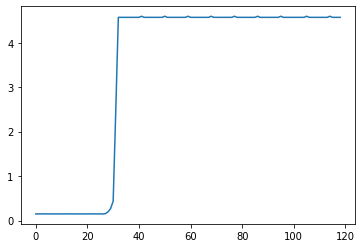

time: 240 ms


In [8]:
plt.plot(np.diff(t_collect))
print(r_vec_collect_local[0,:,7])

In [31]:
t_collect[0:11].shape

(11,)

time: 3 ms


In [6]:
from sunRay.statisticalRays import collectXYtatR,centroidXYFWHM, variationXYFWHM,FWHM

(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_free_stat) = collectXYtatR(photon_N,r_vec_collect_local,k_vec_collect_local,t_collect,tau_collect_local,omega0)

(xc,yc,sx,sy,err_xc,err_yc,err_sx,err_sy) = centroidXYFWHM(
    x_im_stat,y_im_stat,weights_stat)


# to be finished extract useful information

time: 21.1 s


In [7]:

(t_bin_center,flux_all,xc_all,yc_all,sx_all,sy_all,err_xc_all,err_yc_all,
        err_sx_all,err_sy_all) = variationXYFWHM(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,num_t_bins=100)

FWHM_range = FWHM(t_bin_center,flux_all)
duration_cur  =  FWHM_range[1]-FWHM_range[0]

time: 40 ms


In [18]:
import sunRay.statisticalRays as raystat 

time: 998 µs


In [20]:
(r_vec_stat_avail,k_vec_stat_avail,t_reach_stat_avail,tau_stat_avail,
            r_vec_0, k_vec_0) =  raystat.reduct_lv1(
                photon_N,r_vec_collect_local,k_vec_collect_local,
                t_collect,tau_collect_local,omega0,num_t_bins=60)

time: 15.6 s


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

time: 3 ms


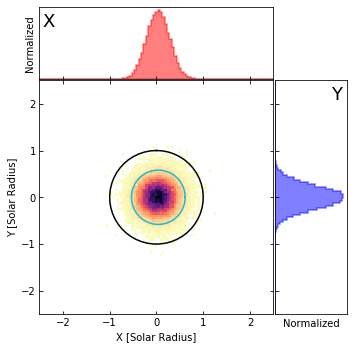

time: 1.02 s


In [8]:
#hst = plt.hist2d(x_im_stat,y_im_stat,bins=[np.linspace(-2,2,100),np.linspace(-2,2,100)],weights=np.exp(-tau_stat))
#plt.axis('equal')


from sunRay.showPlot import XYDistributionImageHist

XYDistributionImageHist(x_im_stat,y_im_stat,bins_data=np.linspace(-2.5,2.5,100)
            ,weights_data=weights_stat)

0.4102253796636972


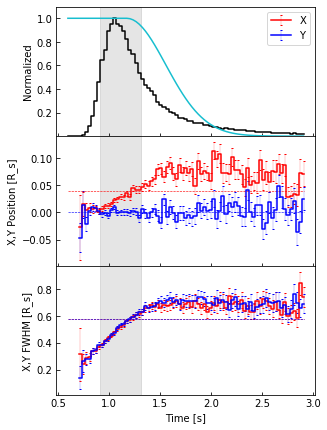

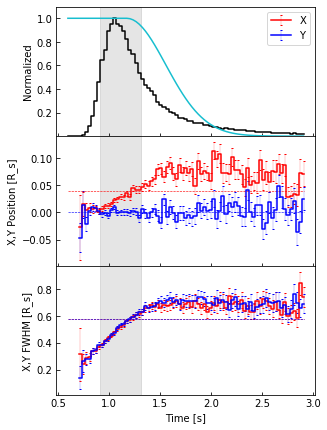

time: 2.41 s


In [17]:
from sunRay.showPlot import XYVariationPlot

XYVariationPlot(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_step = 0.03)

In [27]:
hst = plt.hist(t_reach_1au_stat,150,weights=np.exp(-tau_stat))


In [47]:
215/c_r

499.13275517011346

In [145]:
print(hst[0][20,:])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.22065742e-01 0.00000000e+00 4.40566029e-01 1.70077755e+00
 1.70748397e+00 6.95538646e+00 5.89382475e+00 9.85790884e+00
 1.26816283e+01 2.18808190e+01 2.89920703e+01 4.33193431e+01
 6.20829333e+01 6.96648978e+01 8.87157899e+01 8.75351301e+01
 1.02120347e+02 1.11840275e+02 1.07779498e+02 1.13492928e+02
 1.17933382e+02 1.16222340e+02 1.07980399e+02 9.12755591e+01
 8.95812356e+01 8.26491111e+01 7.54039651e+01 5.97456903e+01
 4.14483934e+01 3.11447867e+01 2.23753065e+01 1.72361751e+01
 1.14423529e+01 2.51488231e+00 1.75856313e+00 1.58451947e+00
 4.89390125e-01 7.68808850e-01 2.72333048e-01 0.00000000e+00
 1.13675706e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.60123366e-01 0.00000000e+00]


In [88]:
x_im_stat.shape
# finish time diff based 
# fit guassian

(217062,)

In [4]:
import sunRay_v0 as sr
import numpy as np
arr_eps   = np.linspace(0.03,0.5,20)
arr_alpha = np.linspace(0.05,0.95,20)

res = sr.run_parset(arr_eps, arr_alpha)

Proc : 1 of 20


In [15]:
np.mean(r_vec_collect_local)

array([[ 50.10711  ,   1.3218341,  20.082058 , ...,   5.1332364,
                nan,  46.651756 ],
       [ -7.4703374, -21.20062  ,  12.607695 , ..., -18.445623 ,
                nan, -25.699118 ],
       [ 45.88431  ,  64.44606  ,  64.07608  , ...,  65.962296 ,
                nan,  42.911858 ]], dtype=float32)

In [5]:
arr_eps[9]

0.25263157894736843

In [ ]:
np.savez('parset.npz',res)

In [8]:
88*c_r

37.90574712643678

In [23]:
r=0.95

0.1+4*r,  0.1+r**0.5

(3.9, 1.0746794344808963)

In [50]:
import numpy as np
data_par  = np.load('parset.npz')

time: 2 ms


In [51]:
res = data_par.f.arr_0

time: 2 ms


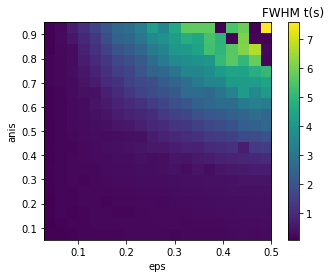

time: 480 ms


In [52]:

arr_eps   = np.linspace(0.03,0.5,20)    
arr_alpha = np.linspace(0.05,0.95,20)

plt.imshow(res[0].T,origin='lower',extent=[np.min(arr_eps),np.max(arr_eps),np.min(arr_alpha),np.max(arr_alpha)])
cbar = plt.colorbar()
cbar.ax.set_title('FWHM t(s)')

ax = plt.gca()
ax.set_xlabel('eps')
ax.set_ylabel('anis')

ax.set_aspect(1/2)
#plt.gca().set_xticks(range(len(arr_eps)))
#plt.gca().set_yticks(range(len(arr_eps)))
#plt.gca().set_yticklabels(arr_alpha)
#plt.gca().set_xticklabels(np.round(arr_eps*100))

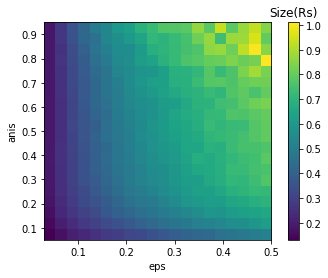

time: 491 ms


In [53]:
plt.close('all')

plt.imshow(res[1].T, origin='lower', extent=[np.min(arr_eps),np.max(arr_eps),np.min(arr_alpha),np.max(arr_alpha)])
cbar = plt.colorbar()
cbar.ax.set_title('Size(Rs)')

ax = plt.gca()
ax.set_xlabel('eps')
ax.set_ylabel('anis')
ax.set_aspect(1/2)

In [11]:
#single test


data  = np.load('datatmp/RUN_[eps0.5]_[alpha0.95].npz')


steps_N  =data.f.steps_N
collect_N =data.f.collect_N
photon_N =data.f.photon_N
start_r =data.f.start_r
start_theta =data.f.start_theta
start_phi  =data.f.start_phi
f_ratio  =data.f.f_ratio
epsilon =data.f.epsilon 
anis =data.f.anis
asym =data.f.asym
omega0 = data.f.omega0
freq0 = data.f.freq0
t_collect=data.f.t_collect
tau=data.f.tau
r_vec_collect_local=data.f.r_vec_collect_local
k_vec_collect_local=data.f.k_vec_collect_local
tau_collect_local = data.f.tau_collect_local

time: 2.39 s


In [12]:

import sunRay.statisticalRays as raystat

(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_free_stat
        ) = raystat.collectXYtatR(photon_N,r_vec_collect_local,
        k_vec_collect_local,t_collect,tau_collect_local,omega0)

(xc,yc,sx,sy,err_xc,err_yc,err_sx,err_sy) = raystat.centroidXYFWHM(
        x_im_stat,y_im_stat,weights_stat)

(t_bin_center,flux_all,xc_all,yc_all,sx_all,sy_all,err_xc_all,err_yc_all,
        err_sx_all,err_sy_all) = raystat.variationXYFWHM(x_im_stat,y_im_stat,
        t_reach_1au_stat,weights_stat,num_t_bins=60)


FWHM_range = raystat.FWHM(t_bin_center,flux_all)


IndexError: index 58 is out of bounds for axis 0 with size 1

0.4581433531204512


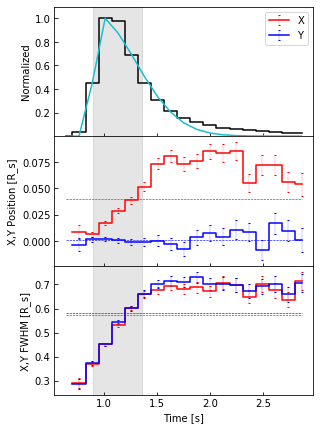

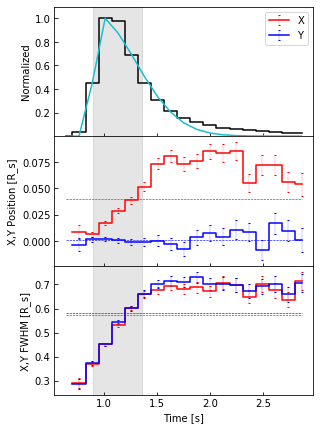

time: 2.14 s


In [13]:
from sunRay.showPlot import XYVariationPlot
XYVariationPlot(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,num_t_bins=20)

In [62]:
t_reach_1au_stat.shape

(146,)

time: 3.01 ms


In [10]:
r_vec_collect_local[-1,:,:]

array([[ 121.01916 ,  -60.02821 ,   75.40926 , ...,    5.955928,
         -83.33347 ,   19.183483],
       [  20.825205,   69.52936 ,  -59.05248 , ..., -128.23021 ,
          21.963173,   52.051132],
       [ 125.11414 ,  149.4002  ,  146.86736 , ...,  119.01273 ,
         152.77402 ,  166.87857 ]], dtype=float32)

time: 4 ms
